In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import spectrogram

from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion

In [45]:
fps = ['./SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './aux_SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './IGRF_SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './SW_EXPT_EFIB_TCT16_1349_20140219T020540_20140219T034014.pkl']

In [3]:
df_b = pd.read_pickle(fps[0])
df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius', 'q_NEC_CRF']]
df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [5]:
st = '20140219T023100'
et = '20140219T024100'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values, df_b_IGRF_clip.index.values))

True

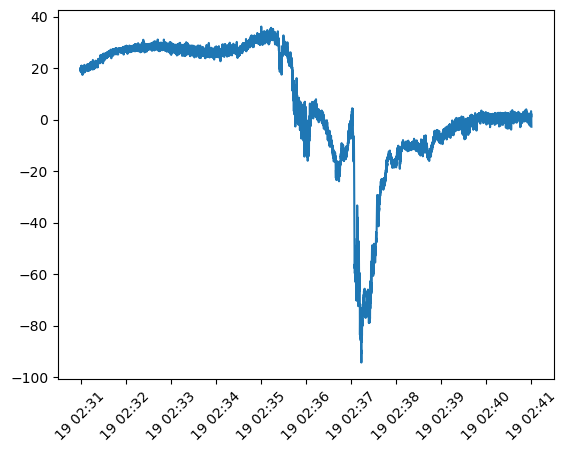

In [8]:
ehx = df_e_clip['Ehx'].values

plt.plot(df_e_clip.index.values, ehx)
plt.xticks(rotation=45)
plt.show()

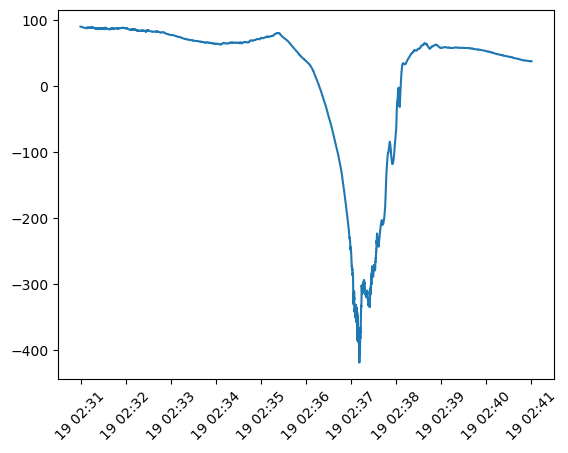

In [9]:
b_sc = []  # b in S/C
b_igrf_sc = []  # igrf b in S/C
for b_nec, b_nec_igrf, q_NEC_CRF in zip(df_b_clip['B_NEC'].values, df_b_IGRF_clip['B_NEC_IGRF'].values,
                                        df_b_clip['q_NEC_CRF'].values):
    q_CRF_NEC = np.array([-q_NEC_CRF[0], -q_NEC_CRF[1], -q_NEC_CRF[2], q_NEC_CRF[3]])
    b_sc.append(rotate_vector_by_quaternion(b_nec, q_CRF_NEC))
    b_igrf_sc.append(rotate_vector_by_quaternion(b_nec_igrf, q_CRF_NEC))
b_sc = np.array(b_sc)
b_igrf_sc = np.array(b_igrf_sc)

by1 = b_sc[:, 1] - b_igrf_sc[:, 1]

plt.plot(df_b_clip.index.values, by1)
plt.xticks(rotation=45)
plt.show()

In [10]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.align_high2low(by1, datetimes_b, datetimes_e)

In [11]:
fs = 16
window = 'hann'
stft_window_seconds = 4  # second
nperseg = int(stft_window_seconds * fs)  # 每个窗的采样点数
noverlap = nperseg // 2  # 50%重叠

freqs, ts, Sxx_e = spectrogram(ehx, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')  # psd
_, _, Sxx_b = spectrogram(by1, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

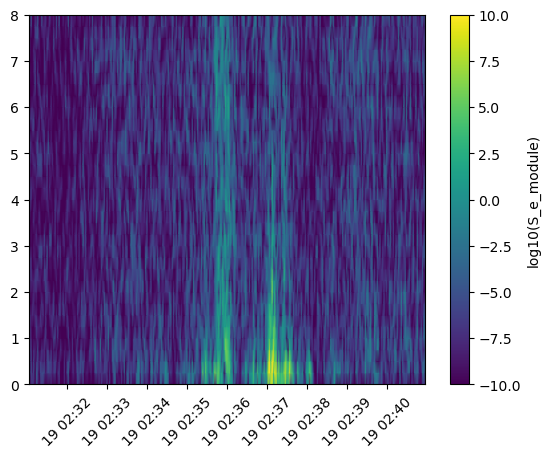

In [12]:
Sxx_e_m = np.abs(Sxx_e)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_e_m), shading='gouraud', vmin=-10, vmax=10)  # 可以用初始值也可以用log10
plt.colorbar(label='log10(P_e)')
plt.xticks(rotation=45)
plt.show()

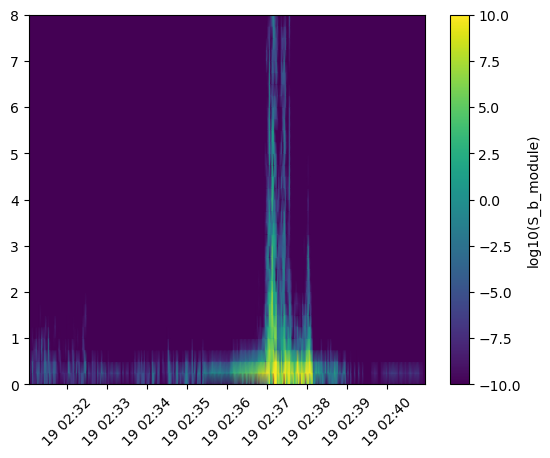

In [13]:
Sxx_b_m = np.abs(Sxx_b)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_b_m), shading='gouraud', vmin=-10, vmax=10)
plt.colorbar(label='log10(P_b)')
plt.xticks(rotation=45)
plt.show()

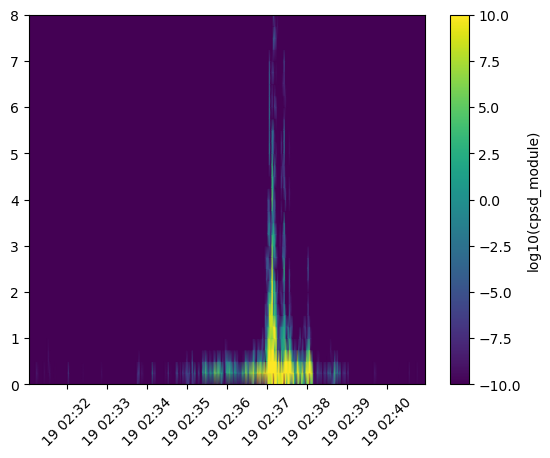

In [14]:
cpsd = Sxx_e * np.conj(Sxx_b)

cpsd_m = np.abs(cpsd)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(cpsd_m), shading='gouraud', vmin=-10, vmax=10)
plt.xticks(rotation=45)
plt.colorbar(label='log10(cpsd_module)')
plt.show()

In [15]:
step=11
coherences = utils.get_coherences(Sxx_e, Sxx_b, cpsd)

In [16]:
ts_dt64_split = utils.split_array(ts_dt64)

dts_cohe = [utils.get_middle_element(i) for i in ts_dt64_split]

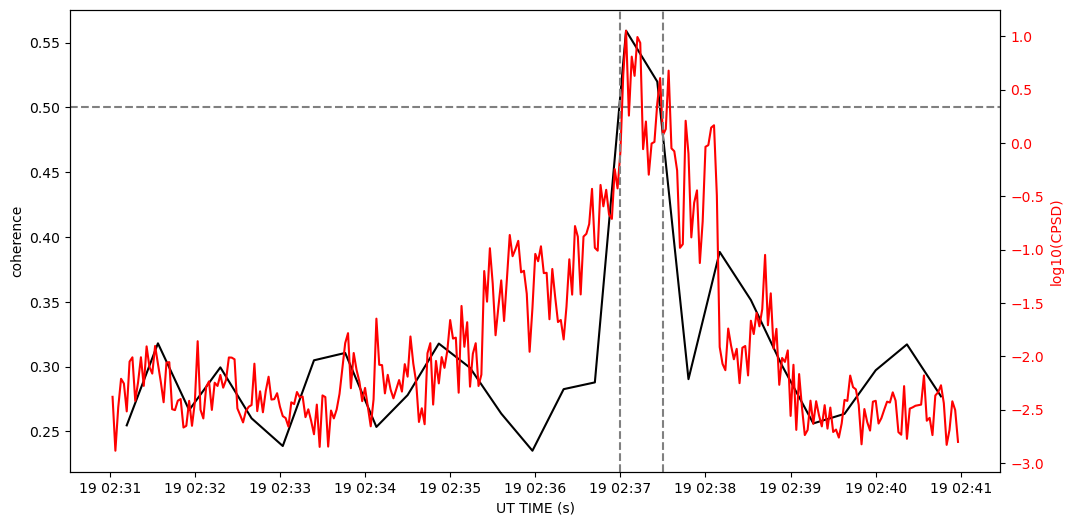

In [17]:
# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first dataset
ax1.plot(dts_cohe, coherences, color='black', label='coherence')
ax1.set_xlabel('UT TIME (s)')
ax1.set_ylabel('coherence', color='black')
ax1.tick_params(axis='y', labelcolor='black')
plt.axhline(0.5, color='gray', linestyle='--')

# Create a second y-axis with its own x-axis
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(ts_dt64, np.log10(cpsd_m.mean(axis=0)), color='red', label='log10(CPSD)')
ax2.set_ylabel('log10(CPSD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

import matplotlib.dates as mdates

plt.axvline(mdates.date2num(np.datetime64('2014-02-19T02:37:00')), color='gray', linestyle='--')
plt.axvline(mdates.date2num(np.datetime64('2014-02-19T02:37:30')), color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.show()

In [18]:
np.max(cpsd_m.sum(axis=0))  # cpsd最大值不可能达到10的20几次方；如果不是对数值，那么cpsd怎么会有负数值？

372.2423788674212

# dynamic: 023700-023730

In [19]:
st_dy = np.datetime64('2014-02-19T02:37:00')
et_dy = np.datetime64('2014-02-19T02:37:30')
t_mask = (datetimes_e >= st_dy) & (datetimes_e <= et_dy)
datetimes_dy = datetimes_e[t_mask]
ehx_dy = ehx[t_mask]
by1_dy = by1[t_mask]

In [20]:
# ehx by1
ehx_dy_fft = utils.FFT(ehx_dy, fs)
by1_dy_fft = utils.FFT(by1_dy, fs)

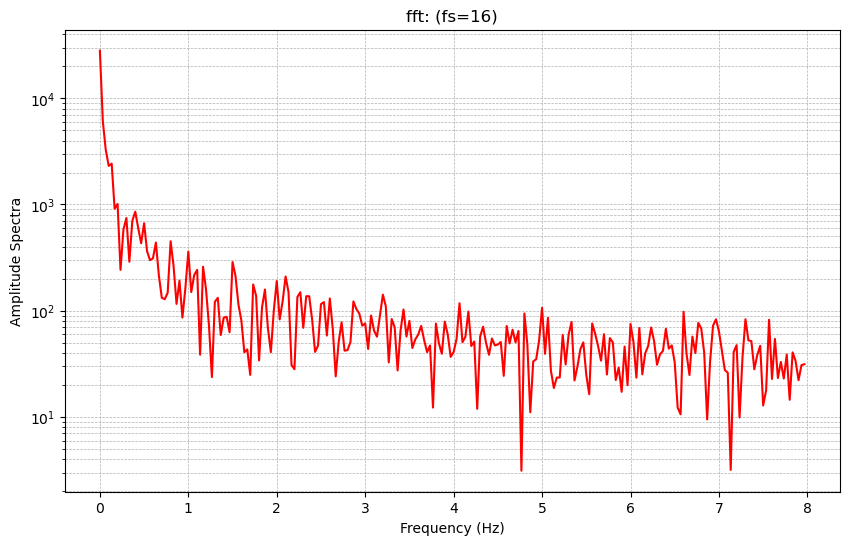

In [21]:
ehx_dy_fft.plot_fft()
plt.show()

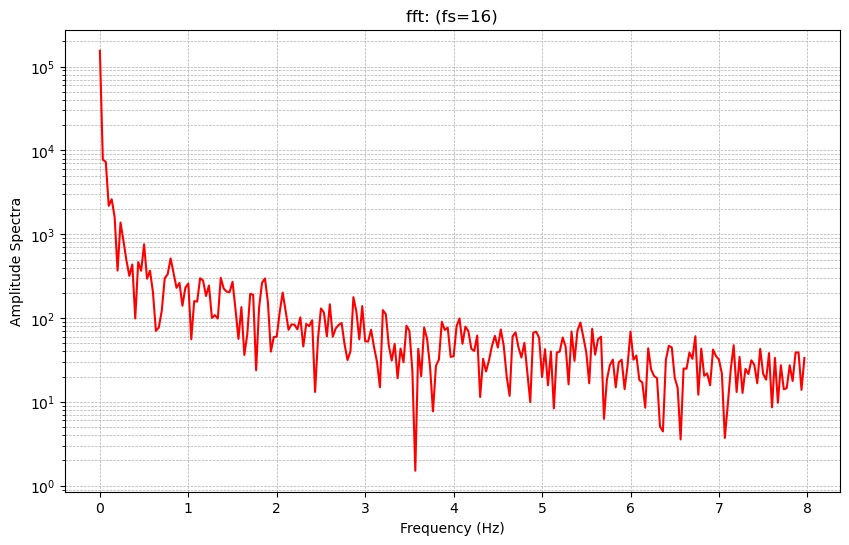

In [22]:
by1_dy_fft.plot_fft()
plt.show()

In [23]:
freqs_dy, amp_e_dy, _ = ehx_dy_fft.get_fft()
_, amp_b_dy, _ = by1_dy_fft.get_fft()

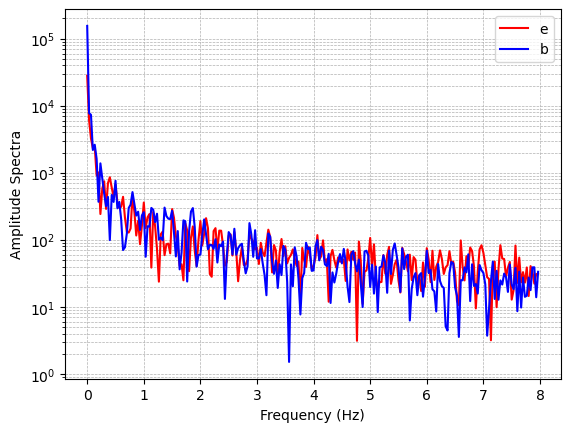

In [24]:
plt.plot(freqs_dy, amp_e_dy, color='red', label='e')
plt.plot(freqs_dy, amp_b_dy, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [25]:
eb_ratio_fft_dy = amp_e_dy / amp_b_dy
eb_ratio_fft_dy = eb_ratio_fft_dy * 1e-3 * 1e9

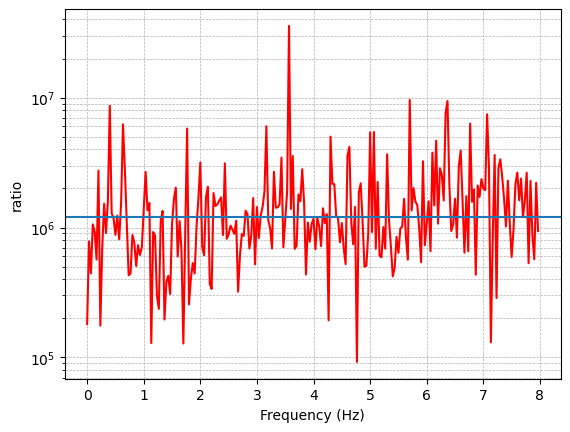

In [26]:
plt.plot(freqs_dy, eb_ratio_fft_dy, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # todo:: 上下边界

In [27]:
freqs_dy, ts_dy, Sxx_e_dy = spectrogram(ehx_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                        mode='complex')
_, _, Sxx_b_dy = spectrogram(by1_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), 's') for _ in ts_dy]

cpsd_dy = Sxx_e_dy * np.conj(Sxx_b_dy)

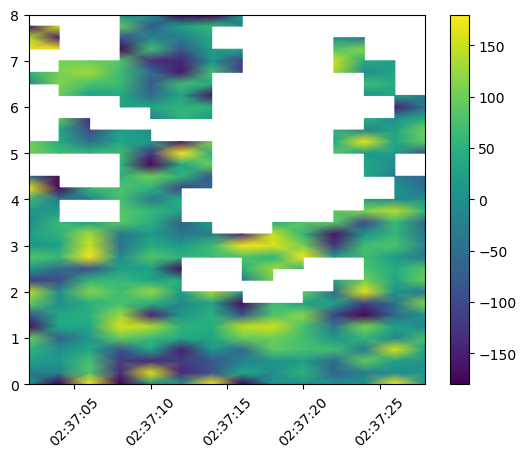

In [28]:
# phase
cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy[cpsd_m_dy < 0.03] = np.nan
plt.pcolormesh(ts_dt64_dy, freqs_dy, cpsd_phase_dy, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [33]:
num_bins = 50
phase_bins_dy, phase_histogram2d_dy = utils.get_phase_histogram2d(freqs_dy, cpsd_phase_dy, num_bins=num_bins)

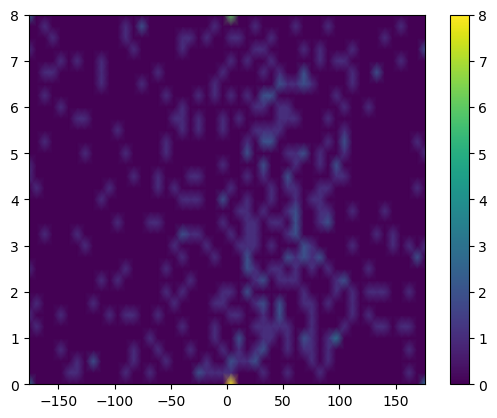

In [34]:
plt.pcolormesh((phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, freqs_dy, phase_histogram2d_dy, shading='gouraud')
plt.colorbar()
plt.show()

In [35]:
phase_bins_dy_ave = utils.get_phase_histogram_f_ave(phase_bins_dy, phase_histogram2d_dy)

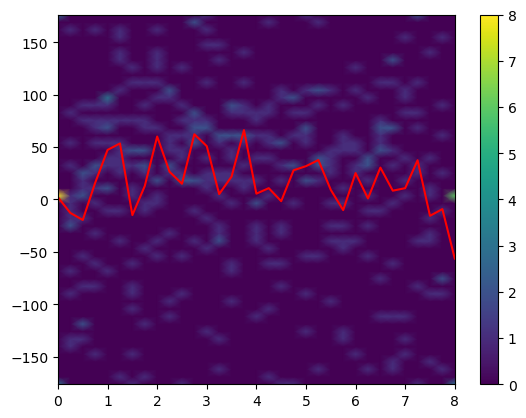

In [36]:
plt.pcolormesh(freqs_dy, (phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, phase_histogram2d_dy.T, shading='gouraud')
plt.plot(freqs_dy, phase_bins_dy_ave, color='r')
plt.colorbar()
plt.show()  # 由于相位差的近似对称分布，所以曲线一般是在0处振荡

# static: 023430-023500

In [37]:
st_sta = np.datetime64('2014-02-19T02:34:30')
et_sta = np.datetime64('2014-02-19T02:35:00')
t_mask = (datetimes_e >= st_sta) & (datetimes_e <= et_sta)
datetimes_sta = datetimes_e[t_mask]
ehx_sta = ehx[t_mask]
by1_sta = by1[t_mask]

In [38]:
# ehx by1
ehx_sta_fft = utils.FFT(ehx_sta, fs)
by1_sta_fft = utils.FFT(by1_sta, fs)

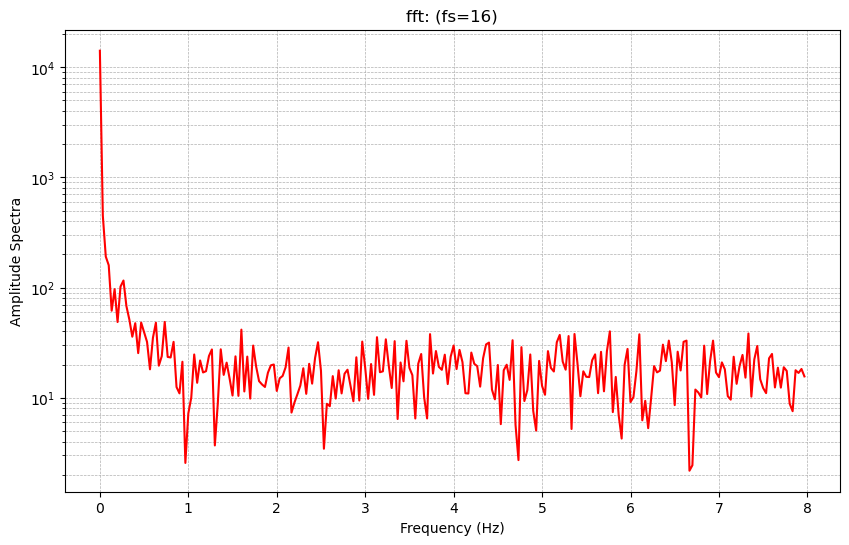

In [39]:
ehx_sta_fft.plot_fft()
plt.show()

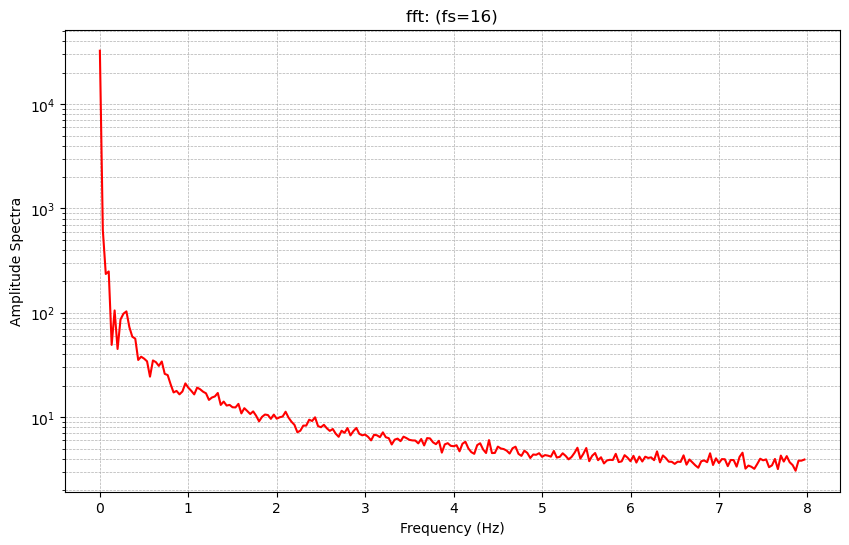

In [40]:
by1_sta_fft.plot_fft()
plt.show()

In [41]:
freqs_sta, amp_e_sta, _ = ehx_sta_fft.get_fft()
_, amp_b_sta, _ = by1_sta_fft.get_fft()

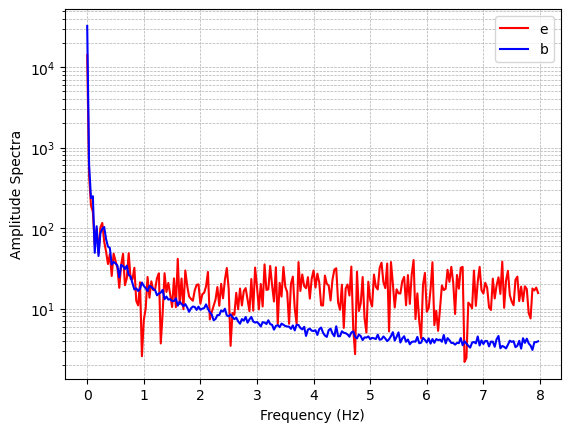

In [42]:
plt.plot(freqs_sta, amp_e_sta, color='red', label='e')
plt.plot(freqs_sta, amp_b_sta, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [43]:
eb_ratio_fft_sta = amp_e_sta / amp_b_sta
eb_ratio_fft_sta = eb_ratio_fft_sta * 1e-3 * 1e9

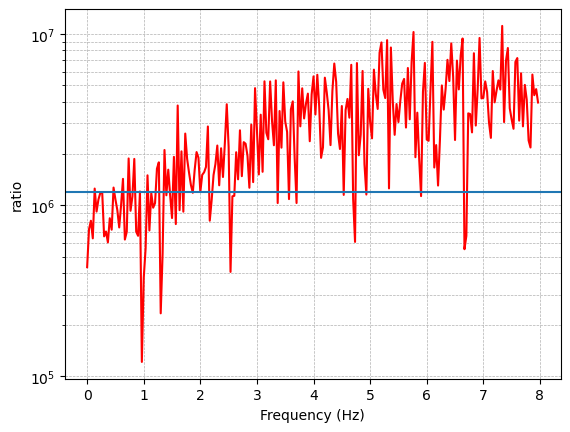

In [35]:
plt.plot(freqs_sta, eb_ratio_fft_sta, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [36]:
freqs_sta, ts_sta, Sxx_e_sta = spectrogram(ehx_sta, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                           mode='complex')
_, _, Sxx_b_sta = spectrogram(by1_sta, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_sta = datetimes_sta[0] + [np.timedelta64(int(_), 's') for _ in ts_sta]

cpsd_sta = Sxx_e_sta * np.conj(Sxx_b_sta)

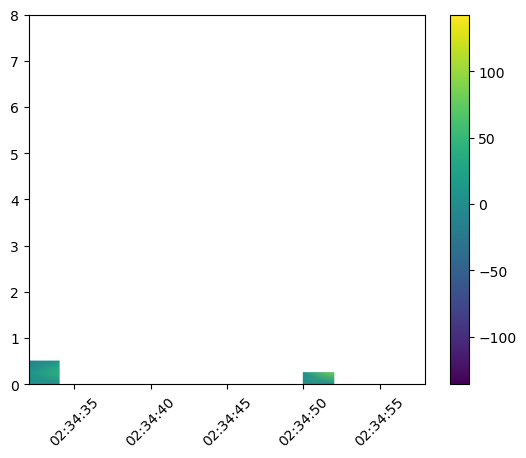

In [37]:
# phase
cpsd_phase_sta = np.degrees(np.angle(cpsd_sta))
cpsd_m_sta = np.abs(cpsd_sta)
cpsd_phase_sta[cpsd_m_sta < 0.03] = np.nan
plt.pcolormesh(ts_dt64_sta, freqs_sta, cpsd_phase_sta, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()